# Project Idea
In this notebook, we are going to train a model to classify image to melanoma vs not melanoma.

# 1. Importing dataset
We will use a [melanoma](https://www.kaggle.com/datasets/drscarlat/melanoma) from kaggle.

This dataset is divided to three parts: train, valid and test. Each one is divided to melanoma and not melanoma.

In [ ]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download drscarlat/melanoma

100%|█████████████████████████████████████| 5.26G/5.26G [2:30:05<00:00, 654kB/s]
100%|█████████████████████████████████████| 5.26G/5.26G [2:30:05<00:00, 627kB/s]


In [ ]:
! unzip 'melanoma.zip'

## Importing important libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
from tensorflow import keras

In [4]:
import os

In [5]:
! pip3 install jedi==0.17.2

You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [6]:
%config Completer.use_jedi = False

In [7]:
PATH = os.getcwd()

In [8]:
print(PATH)

/Users/omarihab/Downloads/Skin_cancer_classification


## Data path
We set our train, test and validation directories to be able to get images thorugh tf.Data API

In [9]:
train_dir = os.path.join(PATH, 'DermMel/train')

In [10]:
valid_dir = os.path.join(PATH, 'DermMel/valid')
test_dir = os.path.join(PATH, 'DermMel/test')

In [11]:
print(valid_dir)
print(train_dir)
print(test_dir)

/Users/omarihab/Downloads/Skin_cancer_classification/DermMel/valid
/Users/omarihab/Downloads/Skin_cancer_classification/DermMel/train
/Users/omarihab/Downloads/Skin_cancer_classification/DermMel/test


In [12]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

## tf.Data API
Data API makes it easier to retrieve data from directories and prepare it for the modeling part.

In [13]:
train_ds = keras.utils.image_dataset_from_directory(train_dir, 
                                        labels= 'inferred', 
                                        batch_size= BATCH_SIZE, 
                                        image_size= IMG_SIZE)

Found 10682 files belonging to 2 classes.
Metal device set to: Apple M1


2022-06-29 14:53:47.702477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-29 14:53:47.702871: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
valid_ds = keras.utils.image_dataset_from_directory(valid_dir,
                                                   labels= 'inferred',
                                                   batch_size= BATCH_SIZE,
                                                   image_size= IMG_SIZE)

Found 3562 files belonging to 2 classes.


In [15]:
test_ds = keras.utils.image_dataset_from_directory(test_dir,
                                                  labels= 'inferred',
                                                  batch_size= BATCH_SIZE,
                                                  image_size= IMG_SIZE)

Found 3561 files belonging to 2 classes.


### Printing samples of our train data

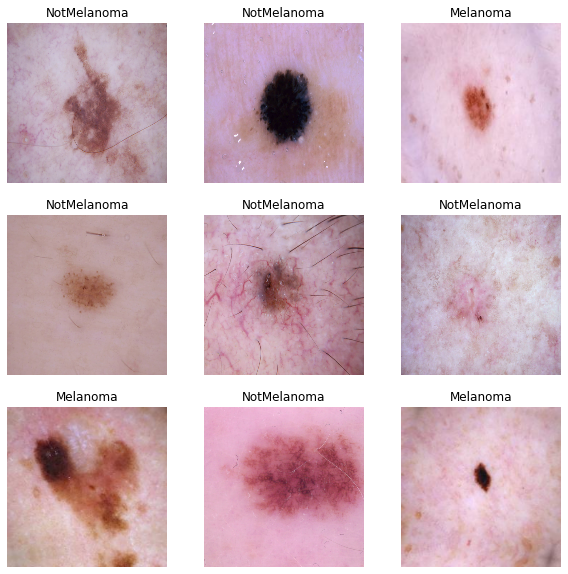

In [47]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# 2. Modeling
We are going to use transfer learning technique.

One of the simplist models that don't have large number of parameters in MobileNet. 

In [18]:
IMG_SHAPE = IMG_SIZE + (3,)

As we can see, MobileNet was originally trained on ImageNet.So, we are going to get these weights to reuse in our task.

In [20]:
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                              input_shape= IMG_SHAPE,
                                              weights= 'imagenet')

In [21]:
base_model.trainable = False

In [22]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [23]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training= False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [26]:
root_lod_dir = os.path.join(os.curdir, 'my_logs_mobilenet2')

In [27]:
import time

In [28]:
def get_run_log_dir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_lod_dir, run_id)

In [29]:
run_log_dir = get_run_log_dir()

In [30]:
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)
history = model.fit(x= train_dataset, epochs=10, validation_data= validation_dataset)

Epoch 1/10


2022-06-29 14:54:45.287020: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-29 14:54:45.287814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - ETA: 0s - loss: 0.4966 - accuracy: 0.7377

2022-06-29 14:55:37.273468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - 70s 202ms/step - loss: 0.4966 - accuracy: 0.7377 - val_loss: 0.2836 - val_accuracy: 0.9037
Epoch 2/10
334/334 [==============================] - 67s 201ms/step - loss: 0.2675 - accuracy: 0.8933 - val_loss: 0.2164 - val_accuracy: 0.9225
Epoch 3/10
334/334 [==============================] - 68s 202ms/step - loss: 0.2231 - accuracy: 0.9110 - val_loss: 0.1967 - val_accuracy: 0.9273
Epoch 4/10
334/334 [==============================] - 68s 202ms/step - loss: 0.2068 - accuracy: 0.9166 - val_loss: 0.1858 - val_accuracy: 0.9276
Epoch 5/10
334/334 [==============================] - 68s 202ms/step - loss: 0.1952 - accuracy: 0.9204 - val_loss: 0.1801 - val_accuracy: 0.9281
Epoch 6/10
334/334 [==============================] - 68s 204ms/step - loss: 0.1902 - accuracy: 0.9222 - val_loss: 0.1766 - val_accuracy: 0.9312
Epoch 7/10
334/334 [==============================] - 68s 202ms/step - loss: 0.1869 - accuracy: 0.9207 - val_loss: 0.1723 - val_accuracy: 0.9

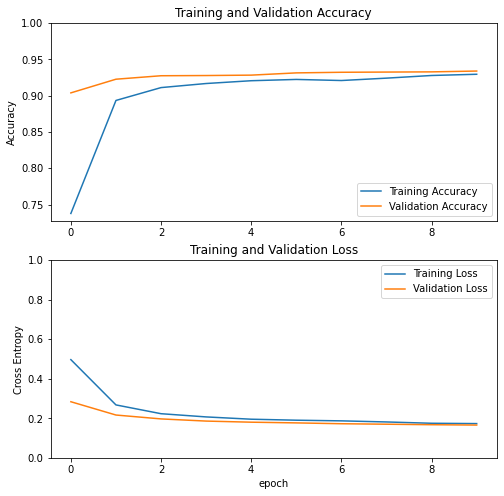

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
base_model.trainable = True

In [33]:
fine_tune_from_layer = 100
for layer in base_model.layers[:100]:
    layer.trainable = False

In [34]:
new_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=new_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [35]:
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)
checkpoint_path = "training_1_mobilenet2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, verbose=1, save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history_mobilenet2=model.fit(x=train_dataset, validation_data=validation_dataset, epochs = 30, callbacks=[checkpoint_cb, earlystopping_cb, tensorboard_cb])

Epoch 1/30


2022-06-29 15:11:20.518656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.9289

2022-06-29 15:12:31.834057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.14430, saving model to training_1_mobilenet2


2022-06-29 15:12:53.919990: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: training_1_mobilenet2/assets
334/334 [==============================] - 111s 321ms/step - loss: 0.1681 - accuracy: 0.9289 - val_loss: 0.1443 - val_accuracy: 0.9295
Epoch 2/30
334/334 [==============================] - ETA: 0s - loss: 0.1432 - accuracy: 0.9391
Epoch 2: val_loss improved from 0.14430 to 0.13439, saving model to training_1_mobilenet2
INFO:tensorflow:Assets written to: training_1_mobilenet2/assets
334/334 [==============================] - 107s 319ms/step - loss: 0.1432 - accuracy: 0.9391 - val_loss: 0.1344 - val_accuracy: 0.9405
Epoch 3/30
334/334 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9455
Epoch 3: val_loss improved from 0.13439 to 0.13350, saving model to training_1_mobilenet2
INFO:tensorflow:Assets written to: training_1_mobilenet2/assets
334/334 [==============================] - 108s 321ms/step - loss: 0.1252 - accuracy: 0.9455 - val_loss: 0.1335 - val_accuracy: 0.9433
Epoch 4/30
334/334 [===========

In [36]:
! tensorboard --logdir=./my_logs --port=6006

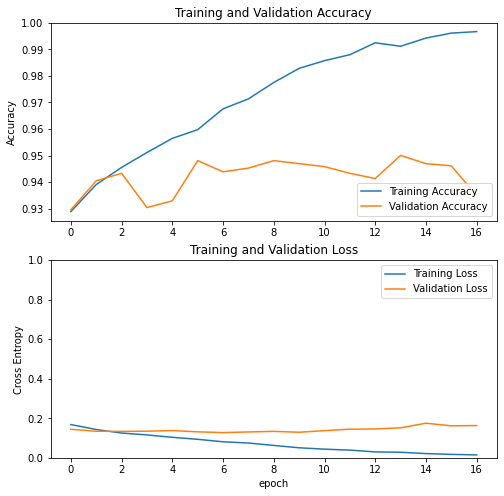

In [37]:
acc = history_mobilenet2.history['accuracy']
val_acc = history_mobilenet2.history['val_accuracy']

loss = history_mobilenet2.history['loss']
val_loss = history_mobilenet2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
model.save('mobilenetv2.h5')

In [39]:
loss, accuracy = model.evaluate(test_dataset)

112/112 [==============================] - 17s 151ms/step - loss: 0.1444 - accuracy: 0.9416


In [40]:
print('Test accuracy ', accuracy)
print('Test loss ', loss)

Test accuracy  0.9415894746780396
Test loss  0.14440792798995972


Predictions:
 [1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1]
Labels:
 [1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1]


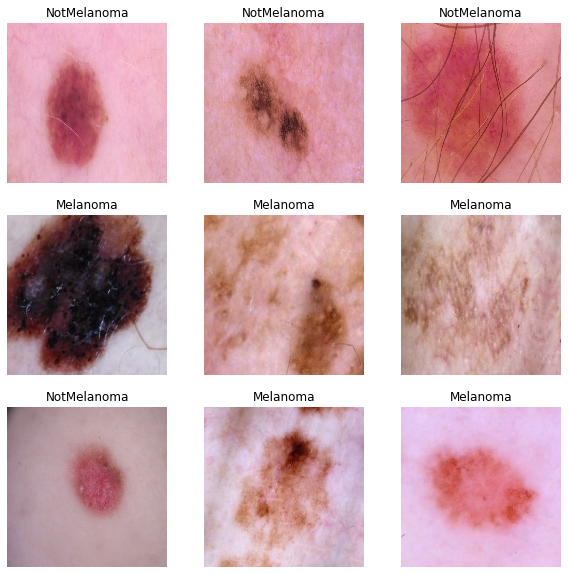

In [48]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [83]:
all_predictions = model.predict(test_ds).flatten()

In [84]:
print(all_predictions)

[-11.218213  -13.872649  -10.24211   ...   7.5802155   3.351998
   6.631281 ]


In [73]:
y = np.concatenate([y for x, y in test_ds], axis=0)

In [74]:
print(y)

[1 1 0 ... 1 0 1]


In [76]:
test_label= y
print(test_label)

[1 1 0 ... 1 0 1]


In [90]:
all_predictions = tf.nn.sigmoid(all_predictions)
all_predictions = tf.where(all_predictions < 0.5, 0, 1)

In [91]:
print(all_predictions.numpy())

[0 0 0 ... 1 1 1]


In [92]:
print(classification_report(test_label, all_predictions, target_names=class_names))

              precision    recall  f1-score   support

    Melanoma       0.50      0.47      0.49      1781
 NotMelanoma       0.50      0.53      0.51      1780

    accuracy                           0.50      3561
   macro avg       0.50      0.50      0.50      3561
weighted avg       0.50      0.50      0.50      3561



In [93]:
tn, fp, fn, tp = confusion_matrix(test_label, all_predictions).ravel()

In [94]:
print('True Positive ', tp)
print('True Negative ', tn)
print('False Positive ', fp)
print('False Negative ', fn)



True Positive  938
True Negative  843
False Positive  938
False Negative  842


# 2.2 XceptionNet

In [23]:
XCE_IMG_SIZE = (160, 160)
XCE_IMG_SHAPE = XCE_IMG_SIZE+(3,)

In [24]:
xception_base_model = tf.keras.applications.xception.Xception(include_top=False,weights='imagenet', input_shape=XCE_IMG_SHAPE)

83697664/83683744 [==============================] - 26s 0us/step


In [26]:
xception_base_model.trainable= False

In [27]:
xception_base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 79, 79, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 20, 20, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 20, 20, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)                                                                                        
                                                                                                  
 conv2d_2 (Conv2D)              (None, 10, 10, 728)  186368      ['add_1[0][0]']                  
                                                                                                  
 block4_po

                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 10, 10, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 10, 10, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block7_sepconv2 (SeparableConv  (None, 10, 10, 728)  536536     ['block7_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_se

                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 10, 10, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 10, 10, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block10_sepconv1_bn (BatchNorm  (None, 10, 10, 728)  2912       ['block10_sepconv1[0][0]']       
 alization)                                                                                       
          

 block12_sepconv3 (SeparableCon  (None, 10, 10, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 10, 10, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (Add)                   (None, 10, 10, 728)  0           ['block12_sepconv3_bn[0][0]',    
                                                                  'add_9[0][0]']                  
                                                                                                  
 block13_sepconv1_act (Activati  (None, 10, 10, 728)  0          ['add_10[0][0]']                 
 on)      

In [28]:
xception_inputs = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.xception.preprocess_input(xception_inputs)
x = xception_base_model(x, training= False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
xception_outputs = tf.keras.layers.Dense(1)(x)
xception_model = tf.keras.Model(xception_inputs, xception_outputs)

In [29]:
xception_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [30]:
learning_rate = 0.0001
xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [33]:
xception_history = xception_model.fit(x= train_dataset, epochs=10, validation_data= validation_dataset)

Epoch 1/10


2022-06-26 13:17:19.479481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - ETA: 0s - loss: 0.6112 - accuracy: 0.6238

2022-06-26 13:20:31.497012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - 254s 742ms/step - loss: 0.6112 - accuracy: 0.6238 - val_loss: 0.5296 - val_accuracy: 0.7274
Epoch 2/10
334/334 [==============================] - 245s 732ms/step - loss: 0.5009 - accuracy: 0.7395 - val_loss: 0.4646 - val_accuracy: 0.7813
Epoch 3/10
334/334 [==============================] - 248s 742ms/step - loss: 0.4518 - accuracy: 0.7868 - val_loss: 0.4270 - val_accuracy: 0.8038
Epoch 4/10
334/334 [==============================] - 249s 745ms/step - loss: 0.4214 - accuracy: 0.8072 - val_loss: 0.4012 - val_accuracy: 0.8186
Epoch 5/10
334/334 [==============================] - 248s 741ms/step - loss: 0.3999 - accuracy: 0.8203 - val_loss: 0.3821 - val_accuracy: 0.8299
Epoch 6/10
334/334 [==============================] - 249s 746ms/step - loss: 0.3833 - accuracy: 0.8287 - val_loss: 0.3671 - val_accuracy: 0.8419
Epoch 7/10
334/334 [==============================] - 245s 734ms/step - loss: 0.3703 - accuracy: 0.8357 - val_loss: 0.3549 - val_accura

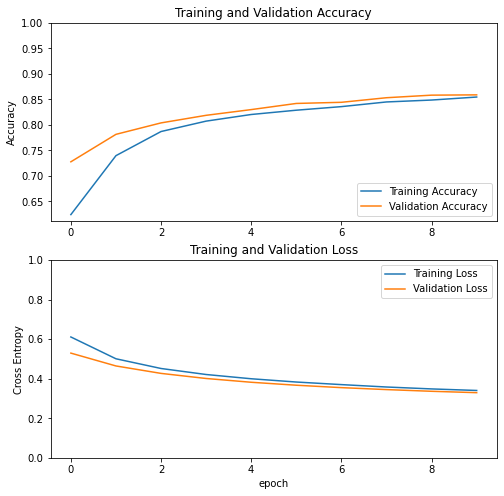

In [35]:
acc = xception_history.history['accuracy']
val_acc = xception_history.history['val_accuracy']

loss = xception_history.history['loss']
val_loss = xception_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
xception_base_model.trainable = True

In [38]:
root_lod_dir = os.path.join(os.curdir, 'my_logs_xception')

In [39]:
import time

In [58]:
def get_run_log_dir(root_dir):
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_dir, run_id)

In [41]:
run_log_dir = get_run_log_dir()

In [43]:
new_learning_rate = 0.00001
xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=new_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [44]:
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)
checkpoint_path = "training_xception/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, verbose=1, save_best_only=True, save_weights_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
xception_history_finetune = xception_model.fit(x=train_dataset, validation_data=validation_dataset, epochs = 20, callbacks=[checkpoint_cb, earlystopping_cb, tensorboard_cb])

Epoch 1/20


2022-06-26 14:58:36.003994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9199

2022-06-26 15:07:12.989372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.13706, saving model to training_xception
334/334 [==============================] - 582s 2s/step - loss: 0.1883 - accuracy: 0.9199 - val_loss: 0.1371 - val_accuracy: 0.9394
Epoch 2/20
334/334 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9480
Epoch 2: val_loss improved from 0.13706 to 0.13320, saving model to training_xception
334/334 [==============================] - 572s 2s/step - loss: 0.1223 - accuracy: 0.9480 - val_loss: 0.1332 - val_accuracy: 0.9408
Epoch 3/20
334/334 [==============================] - ETA: 0s - loss: 0.0875 - accuracy: 0.9640
Epoch 3: val_loss did not improve from 0.13320
334/334 [==============================] - 571s 2s/step - loss: 0.0875 - accuracy: 0.9640 - val_loss: 0.1335 - val_accuracy: 0.9380
Epoch 4/20
334/334 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9804
Epoch 4: val_loss did not improve from 0.13320
334/334 [==============================] - 568s 2s/st

KeyboardInterrupt: 

In [57]:
xception_model.save('Xception.h5')

# EfficientNetV2B0

In [46]:
eff_base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=XCE_IMG_SHAPE)

24289280/24274472 [==============================] - 7s 0us/step


In [47]:
eff_base_model.trainable = False

In [48]:
eff_base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 80, 80, 32)   864         ['normalization[0

                                                                                                  
 block3b_add (Add)              (None, 20, 20, 48)   0           ['block3b_project_bn[0][0]',     
                                                                  'block3a_project_bn[0][0]']     
                                                                                                  
 block4a_expand_conv (Conv2D)   (None, 20, 20, 192)  9216        ['block3b_add[0][0]']            
                                                                                                  
 block4a_expand_bn (BatchNormal  (None, 20, 20, 192)  768        ['block4a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4a_expand_activation (Act  (None, 20, 20, 192)  0          ['block4a_expand_bn[0][0]']      
 ivation) 

 block4c_dwconv2 (DepthwiseConv  (None, 10, 10, 384)  3456       ['block4c_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4c_bn (BatchNormalization  (None, 10, 10, 384)  1536       ['block4c_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block4c_activation (Activation  (None, 10, 10, 384)  0          ['block4c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4c_se_squeeze (GlobalAver  (None, 384)         0           ['block4c_activation[0][0]']     
 agePoolin

 block5b_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5b_se_squeeze[0][0]']     
                                                                                                  
 block5b_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_se_excite (Multiply)   (None, 10, 10, 672)  0           ['block5b_activation[0][0]',     
                                                                  'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, 10, 10, 112)  75264       ['block5b_se_excite[0][0]']      
          

 block5d_project_conv (Conv2D)  (None, 10, 10, 112)  75264       ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 10, 10, 112)  448        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_add (Add)              (None, 10, 10, 112)  0           ['block5d_project_bn[0][0]',     
                                                                  'block5c_add[0][0]']            
                                                                                                  
 block5e_expand_conv (Conv2D)   (None, 10, 10, 672)  75264       ['block5d_add[0][0]']            
                                                                                                  
 block5e_e

                                                                                                  
 block6b_expand_activation (Act  (None, 5, 5, 1152)  0           ['block6b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6b_dwconv2 (DepthwiseConv  (None, 5, 5, 1152)  10368       ['block6b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 5, 5, 1152)  4608        ['block6b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6b_a

                                                                                                  
 block6d_activation (Activation  (None, 5, 5, 1152)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6d_se_reshape[0][0]']     
          

 block6f_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 5, 5, 1152)   0           ['block6f_activation[0][0]',     
                                                                  'block6f_se_expand[0][0]']      
                                                                                                  
 block6f_project_conv (Conv2D)  (None, 5, 5, 192)    221184      ['block6f_se_excite[0][0]']      
                                                                                                  
 block6f_project_bn (BatchNorma  (None, 5, 5, 192)   768         ['block6f_project_conv[0][0]']   
 lization)

 block6h_project_bn (BatchNorma  (None, 5, 5, 192)   768         ['block6h_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6h_add (Add)              (None, 5, 5, 192)    0           ['block6h_project_bn[0][0]',     
                                                                  'block6g_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, 5, 5, 1280)   245760      ['block6h_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 5, 5, 1280)   5120        ['top_conv[0][0]']               
                                                                                                  
 top_activ

In [51]:
eff_inputs = tf.keras.Input(shape=(160, 160, 3))
x = eff_base_model(eff_inputs, training= False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
eff_outputs = tf.keras.layers.Dense(1)(x)
eff_model = tf.keras.Model(eff_inputs, eff_outputs)

In [52]:
eff_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 5, 5, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 1,281
Non-trainab

In [53]:
learning_rate = 0.0001
eff_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [54]:
eff_history = eff_model.fit(x= train_dataset, epochs=10, validation_data= validation_dataset)

Epoch 1/10


2022-06-26 16:00:07.913328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.6951

2022-06-26 16:01:09.424500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - 86s 234ms/step - loss: 0.5521 - accuracy: 0.6951 - val_loss: 0.4724 - val_accuracy: 0.7835
Epoch 2/10
334/334 [==============================] - 74s 219ms/step - loss: 0.4272 - accuracy: 0.8074 - val_loss: 0.3916 - val_accuracy: 0.8304
Epoch 3/10
334/334 [==============================] - 74s 220ms/step - loss: 0.3661 - accuracy: 0.8437 - val_loss: 0.3472 - val_accuracy: 0.8515
Epoch 4/10
334/334 [==============================] - 74s 221ms/step - loss: 0.3299 - accuracy: 0.8634 - val_loss: 0.3193 - val_accuracy: 0.8633
Epoch 5/10
334/334 [==============================] - 74s 222ms/step - loss: 0.3066 - accuracy: 0.8750 - val_loss: 0.3000 - val_accuracy: 0.8706
Epoch 6/10
334/334 [==============================] - 74s 222ms/step - loss: 0.2892 - accuracy: 0.8781 - val_loss: 0.2862 - val_accuracy: 0.8759
Epoch 7/10
334/334 [==============================] - 74s 221ms/step - loss: 0.2781 - accuracy: 0.8836 - val_loss: 0.2756 - val_accuracy: 0.8

In [55]:
eff_base_model.trainable = True

In [56]:
eff_root_lod_dir = os.path.join(os.curdir, 'my_logs_eff')

In [59]:
eff_run_log_dir = get_run_log_dir(eff_root_lod_dir)

In [60]:
new_learning_rate = 0.00001
eff_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=new_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [61]:
tensorboard_cb = keras.callbacks.TensorBoard(eff_run_log_dir)
checkpoint_path = "training_efficient/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, verbose=1, save_best_only=True, save_weights_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
efficient_history_finetune = eff_model.fit(x=train_dataset, validation_data=validation_dataset, epochs = 10, callbacks=[checkpoint_cb, earlystopping_cb, tensorboard_cb])

Epoch 1/10


2022-06-26 16:32:13.308534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


334/334 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.9177

2022-06-26 16:35:17.019320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.15654, saving model to training_efficient
334/334 [==============================] - 210s 575ms/step - loss: 0.1910 - accuracy: 0.9177 - val_loss: 0.1565 - val_accuracy: 0.9385
Epoch 2/10
334/334 [==============================] - ETA: 0s - loss: 0.1460 - accuracy: 0.9380
Epoch 2: val_loss improved from 0.15654 to 0.13883, saving model to training_efficient
334/334 [==============================] - 184s 549ms/step - loss: 0.1460 - accuracy: 0.9380 - val_loss: 0.1388 - val_accuracy: 0.9399
Epoch 3/10
334/334 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9497
Epoch 3: val_loss improved from 0.13883 to 0.13676, saving model to training_efficient
334/334 [==============================] - 184s 548ms/step - loss: 0.1253 - accuracy: 0.9497 - val_loss: 0.1368 - val_accuracy: 0.9309
Epoch 4/10
334/334 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9521
Epoch 4: val_loss improved from 0.13676 to 0.1286

In [62]:
eff_model.save('EfficientNetV2B0.h5')

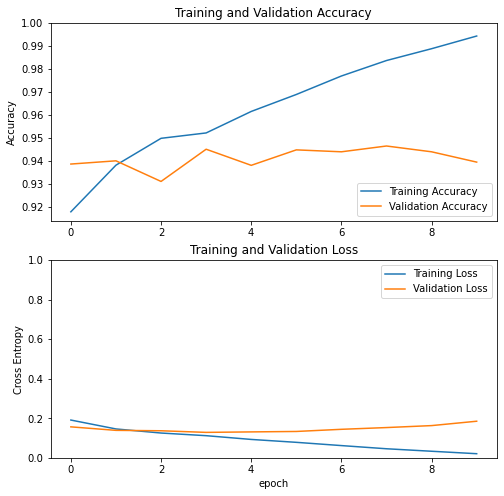

In [63]:
acc = efficient_history_finetune.history['accuracy']
val_acc = efficient_history_finetune.history['val_accuracy']

loss = efficient_history_finetune.history['loss']
val_loss = efficient_history_finetune.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [64]:
loss, accuracy = eff_model.evaluate(test_dataset)

112/112 [==============================] - 21s 184ms/step - loss: 0.2034 - accuracy: 0.9332


In [65]:
print('Test loss ', loss)
print('Test accuracy ', accuracy)

Test loss  0.20341530442237854
Test accuracy  0.9331648945808411


2022-06-26 17:19:23.505149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Predictions:
 [1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1]
Labels:
 [1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1]


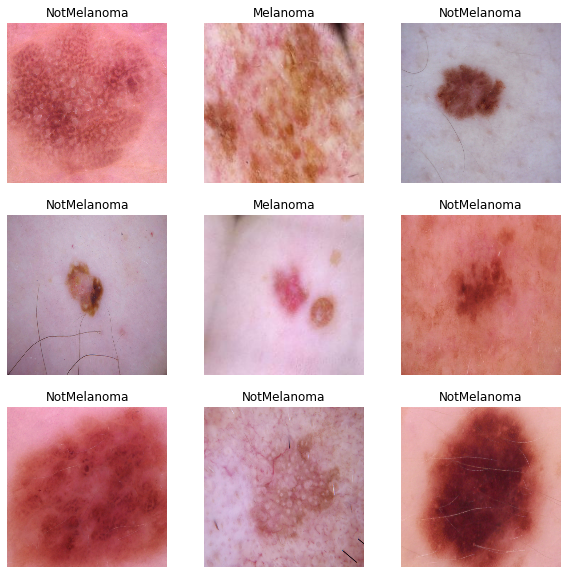

In [66]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = eff_model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [95]:
loaded_eff_model = tf.keras.models.load_model('EfficientNetV2B0.h5')

In [96]:
eff_predictions = loaded_eff_model.predict(test_ds).flatten()

2022-06-29 16:21:55.401346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [97]:
eff_predictions = tf.nn.sigmoid(eff_predictions)
eff_predictions = tf.where(eff_predictions < 0.5, 0, 1)

In [98]:
print(eff_predictions.numpy())

[0 1 0 ... 0 0 1]


In [116]:
y = np.concatenate([y for x, y in test_ds], axis=0)

In [117]:
print(y)

[1 0 1 ... 0 0 0]


In [118]:
print(classification_report(y, eff_predictions, target_names=class_names))

              precision    recall  f1-score   support

    Melanoma       0.50      0.51      0.50      1781
 NotMelanoma       0.50      0.49      0.49      1780

    accuracy                           0.50      3561
   macro avg       0.50      0.50      0.50      3561
weighted avg       0.50      0.50      0.50      3561



In [119]:
print(confusion_matrix(y, eff_predictions))

[[902 879]
 [915 865]]


In [120]:
tn, fp, fn, tp = confusion_matrix(y, eff_predictions).ravel()

In [121]:
print('True Positive ', tp)
print('True Negative ', tn)
print('False Positive ', fp)
print('False Negative ', fn)


True Positive  865
True Negative  902
False Positive  879
False Negative  915
